### Programming for A&A:

### Assignment 1: Maxwell A. Fine 14880725

This is the alternative Assignment

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [409]:
# functions 

def read_header(data_file_csv):
    '''Reads in the header of the data_file_csv and returns a dictionary which maps the
    station name onto the station number. Uses the open python method.
    
    Also, Reads in the last-but-one line
    of the header with the list of variable names and returns a dictionary to map a variable name to its
    position in the list (starting with 0), i.e. to map a variable to the corresponding column index in the
    data.

    Args:
    data_file_csv: str
                   filename of the data file to read in, expects a .csv file

    Returns:
    stn_dict: dict
              A dict mapping station names to station numbers

    var_dict: dict
              A dict map a variable name to its position in the list (starting with 0)
    '''

    # read in data_file_csv's header
    header_lines = []
    with open(data_file_csv, 'r') as f:
        for line in f:
            if line[0] == '#':
                header_lines.append(line)
            else:
                break

    # stn dict
    # lets map station names to station numbers
    # starts after line with '# STN      LON(east)   LAT(north)     ALT(m)  NAME\n'
    # ends after blank line
    start_value = '# STN      LON(east)   LAT(north)     ALT(m)  NAME\n' 
    start_index = header_lines.index(start_value)
    end_index = 55 # figure out better method later 

    # read in stn names, and stn number data, split along spaces and make dict
    stn_data = header_lines[start_index +1 :end_index]
    stn_dict = {} # init dict
    for line in stn_data:
        stn_number = line[2:5] # assuming a 3 digit number only, will fix later
        split_line = line.split(maxsplit=5) 
        stn_name = split_line[-1][0:-1] # need to remove the \n
        stn_dict[stn_name] = stn_number

    # var_dict
    var_names = header_lines[-2][2:-1].strip().split(',') # makes a list of strings from the 2nd to last line in the header
    var_dict = {var_name.strip(): index for index, var_name in enumerate(var_names)} # fancy one liner
    print(var_dict)
    return stn_dict, var_dict


def read_data(data_file_csv):
    '''Reads in all the data (following the header) in data_file_csv, returning it as a
numpy arr. Empty fields are set to np.nan. The first column (station number) into an integer. The second column
(date) may be kept as a string and be converted or modified later. The remaining
values should be converted into floats (they are continuous values, even if rounded
to whole numbers).
'''
    csv_data = np.genfromtxt(data_file_csv, delimiter=',', skip_header=0,)

    return csv_data # need to make one collum ints, and another str


# data proccesing functions 


def get_monthly_avg(stn_number, csv_data, key, var_dict, set_zero_data=False):
    '''Calculates the monthly averags for a given stn_number for a given data key
    returns an array with 12 of the mean value for the corresponding month 1== January. 
    Uses numpy methods.'''

    # get stn data, and make datetime objs array
    #stn_number = 391.
    #key = 14
    key_index = var_dict[key]
    stn_data  = csv_data[csv_data[:,0] == stn_number]

    float_dates = stn_data[:,1]
    # Convert the NumPy array of floats to datetime objects
    date_int = np.array(float_dates, dtype=int)  # Convert floats to strings
    date_strs = np.array(date_int, dtype=str)  # Convert floats to strings
    date_objs = np.array([datetime.strptime(date_str, '%Y%m%d') for date_str in date_strs])

    # stn_data is [n, 41] we want to sort by month
    months = np.array([date.month for date in date_objs])
    unique_months = np.unique(months)

    monthly_avg = np.zeros(12)
    monthly_std = np.zeros(12)

    for month in unique_months:
            i = month
            mask = (months == month)

            if set_zero_data is True:
                # set all - values to 0
                stn_data[:, key_index][mask][stn_data[:, key_index][mask] < 0] = 0
            monthly_avg[i-1] = np.nanmean(stn_data[:,key_index][mask])
            monthly_std[i-1] = np.nanstd(stn_data[:,key_index][mask])


    return monthly_avg, monthly_std





# plotting functions

def plot_data(station_name, csv_data, var_dict, stn_dict, save=True, format='.pdf', dpi=300):
    
    
    # important keys
    # TN = Minimum temperature (in 0.1 degrees Celsius);
    # TX = Maximum temperature (in 0.1 degrees Celsius);
    # SQ = Sunshine duration (in 0.1 hours) calculated from the global radiation (-1 for <0.05 hours);
    # RH = 24-hour sum of precipitation (in 0.1 mm) (-1 for <0.05 mm);


    stn_number = float(stn_dict[station_name])

    time = np.arange(12)
    time = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(24, 12))

    # Plot data in the first subplot (top-left)
    # max temp
    key = 'TX'
    data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict)
    axs[0, 0].scatter(time, data/10, color='k', linewidth=2, label='Max Temp')
    axs[0,0].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='k', fmt='-.', linewidth=2)
    axs[0,0].set_ylabel('Max Temperature (°C)', size=15,)
    axs[0, 0].set_title('Maximum Temperature (°C)',size=15)
    axs[0,0].set_xlabel('Months', size=15)
    key = 'TN'
    data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict)
    axs[0, 0].scatter(time, data/10, color='blue', linewidth=2, label='Min Temp')
    axs[0, 0].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='blue', fmt='-.', linewidth=2)
    axs[0,0].legend(fontsize=12)
    axs[0,0].tick_params(axis='both', which='major', labelsize=12)


    # Plot data in the second subplot (bottom-right)
    # min temp
    key = 'TN'
    data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict)
    axs[1, 0].scatter(time, data/10, color='k', linewidth=2)
    axs[1, 0].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='k', fmt='-.', linewidth=2)
    axs[1, 0].set_ylabel('Min Temperature (°C))', size=15,)
    axs[1, 0].set_title('Minimum Temperature (°C)',size=15)
    axs[1,0].set_xlabel('Months', size=15)
    axs[1,0].tick_params(axis='both', which='major', labelsize=12)

    # Plot data in the third subplot (top-right)
    # Sunshine duration 
    key = 'SQ'
    data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict, set_zero_data=True)
    axs[0, 1].scatter(time, data/10, color='gold',linewidth=2)
    axs[0, 1].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='gold', fmt='-.', linewidth=2)
    axs[0, 1].set_ylabel('Hours of Sunshine', size=15,)
    axs[0, 1].set_title('Hours of Sunshine',size=15)
    axs[0,1].set_xlabel('Months', size=15)
    axs[0,1].set_ylim(0,12)
    axs[0,1].tick_params(axis='both', which='major', labelsize=12)

    # Plot data in the fourth subplot (bottom-right)
    # 24-hour sum of precipitation (in 0.1 mm) (-1 for <0.05 mm)
    key = 'RH'
    data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict, set_zero_data=True)
    axs[1, 1].scatter(time, data, color='Blue', linewidth=2)
    axs[1, 1].errorbar(time, data, yerr=std_data, xerr=None, color='blue',fmt='-.', linewidth=2)
    axs[1, 1].set_ylabel('Precipitation (mm/hour)', size=15,)
    axs[1, 1].set_title('Precipitation',size=15)
    axs[1,1].set_xlabel('Months', size=15)
    axs[1,1].tick_params(axis='both', which='major', labelsize=12)

    # Adjust spacing between subplots
    plt.suptitle('Weather Station: ' + station_name +'\n Station Number: ' + str(int(stn_number)), size=20)
    plt.xticks(fontsize=12)  # Adjust the fontsize as needed
    #axs.tick_params(axis='both', which='major', labelsize=12)  # Adjust the fontsize as needed
    plt.tight_layout()
    
    if save is True:
        plt.savefig(station_name + '_' + str(int(stn_number)) + format, dpi=dpi, bbox_inches='tight')
    



IJMOND
VALKENBURG
VOORSCHOTEN
IJMUIDEN
DE KOOY
SCHIPHOL
VLIELAND
WIJDENES
BERKHOUT
HOORN (TERSCHELLING)
WIJK AAN ZEE
HOUTRIBDIJK
DE BILT
SOESTERBERG
STAVOREN
LELYSTAD
LEEUWARDEN
MARKNESSE
DEELEN
LAUWERSOOG
HEINO
HOOGEVEEN
EELDE
HUPSEL
HUIBERTGAT
NIEUW BEERTA
TWENTHE
CADZAND
VLISSINGEN
HOOFDPLAAT
OOSTERSCHELDE
VLAKTE V.D. RAAN
HANSWEERT
SCHAAR
WESTDORPE
WILHELMINADORP
STAVENISSE
HOEK VAN HOLLAND
THOLEN
WOENSDRECHT
R'DAM-GEULHAVEN
ROTTERDAM
CABAUW
GILZE-RIJEN
HERWIJNEN
EINDHOVEN
VOLKEL
ELL
MAASTRICHT
ARCEN
{'STN': 0, 'YYYYMMDD': 1, 'DDVEC': 2, 'FHVEC': 3, 'FG': 4, 'FHX': 5, 'FHXH': 6, 'FHN': 7, 'FHNH': 8, 'FXX': 9, 'FXXH': 10, 'TG': 11, 'TN': 12, 'TNH': 13, 'TX': 14, 'TXH': 15, 'T10N': 16, 'T10NH': 17, 'SQ': 18, 'SP': 19, 'Q': 20, 'DR': 21, 'RH': 22, 'RHX': 23, 'RHXH': 24, 'PG': 25, 'PX': 26, 'PXH': 27, 'PN': 28, 'PNH': 29, 'VVN': 30, 'VVNH': 31, 'VVX': 32, 'VVXH': 33, 'NG': 34, 'UG': 35, 'UX': 36, 'UXH': 37, 'UN': 38, 'UNH': 39, 'EV2': 40}


({'IJMOND\n': '209',
  'VALKENBURG\n': '210',
  'VOORSCHOTEN\n': '215',
  'IJMUIDEN\n': '225',
  'DE KOOY\n': '235',
  'SCHIPHOL\n': '240',
  'VLIELAND\n': '242',
  'WIJDENES\n': '248',
  'BERKHOUT\n': '249',
  'HOORN (TERSCHELLING)\n': '251',
  'WIJK AAN ZEE\n': '257',
  'HOUTRIBDIJK\n': '258',
  'DE BILT\n': '260',
  'SOESTERBERG\n': '265',
  'STAVOREN\n': '267',
  'LELYSTAD\n': '269',
  'LEEUWARDEN\n': '270',
  'MARKNESSE\n': '273',
  'DEELEN\n': '275',
  'LAUWERSOOG\n': '277',
  'HEINO\n': '278',
  'HOOGEVEEN\n': '279',
  'EELDE\n': '280',
  'HUPSEL\n': '283',
  'HUIBERTGAT\n': '285',
  'NIEUW BEERTA\n': '286',
  'TWENTHE\n': '290',
  'CADZAND\n': '308',
  'VLISSINGEN\n': '310',
  'HOOFDPLAAT\n': '311',
  'OOSTERSCHELDE\n': '312',
  'VLAKTE V.D. RAAN\n': '313',
  'HANSWEERT\n': '315',
  'SCHAAR\n': '316',
  'WESTDORPE\n': '319',
  'WILHELMINADORP\n': '323',
  'STAVENISSE\n': '324',
  'HOEK VAN HOLLAND\n': '330',
  'THOLEN\n': '331',
  'WOENSDRECHT\n': '340',
  "R'DAM-GEULHAVEN\n": 

panels showing: the monthly averages of
maximum temperature (in Celsius), minimum temperature (in Celsius), daily sum of
precipitation (in mm/hour), duration of sunshine (in hours).

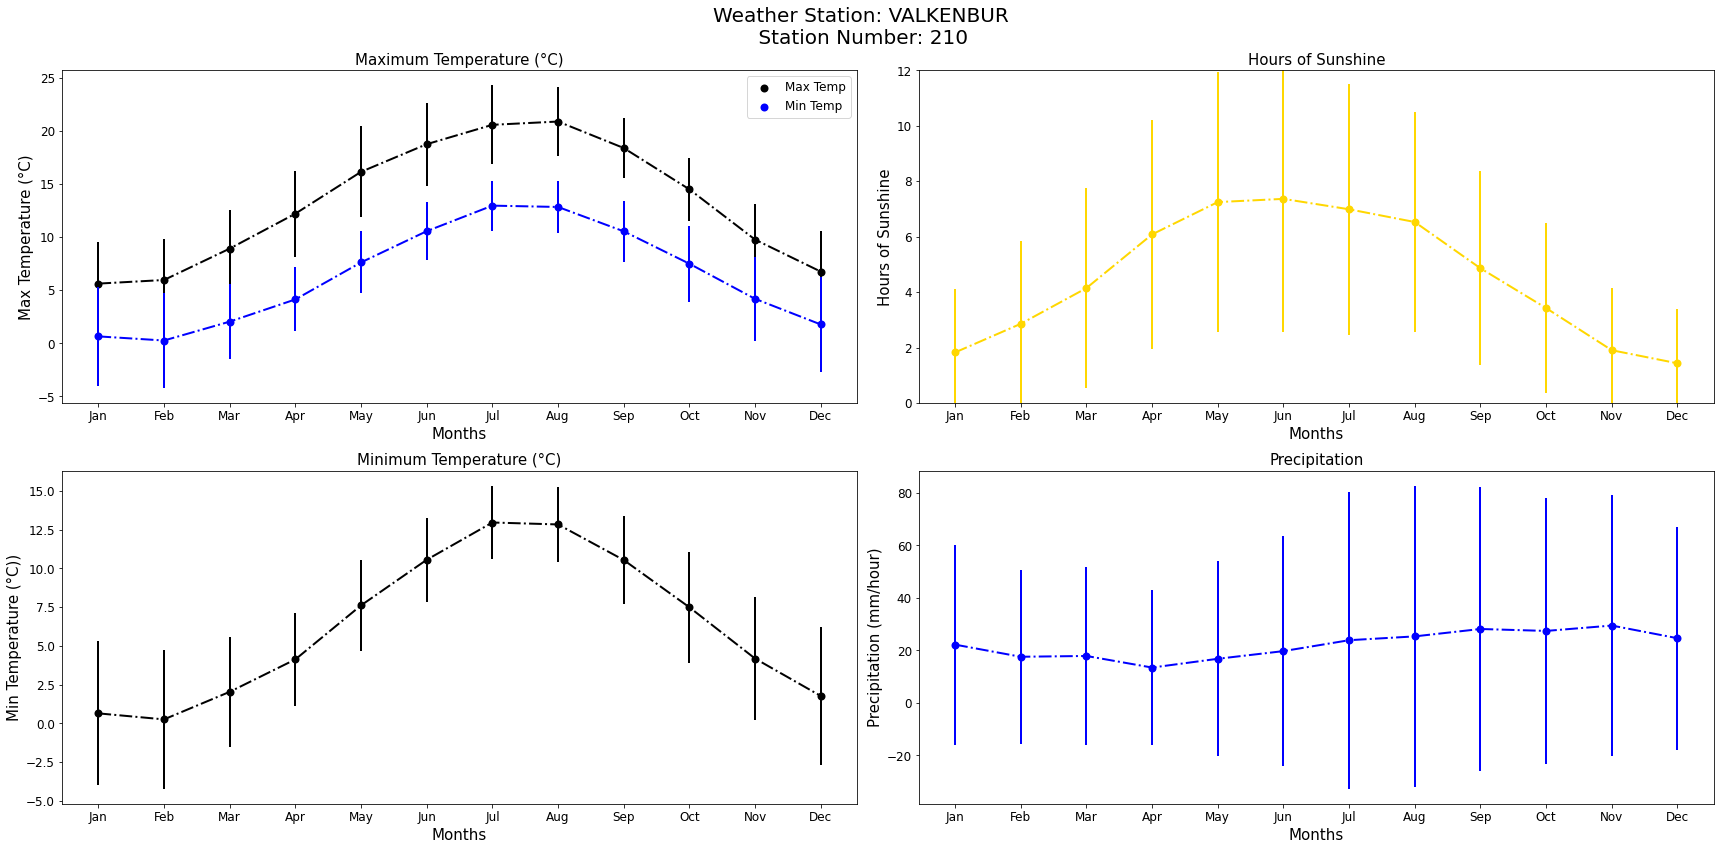

In [279]:
station_name = 'VALKENBUR'
plot_data(station_name, csv_data, var_dict, stn_dict)

In [415]:
# new numpy method for reading in header

def np_read_header(data_file_csv):
    '''Reads in the header of the data_file_csv and returns a dictionary which maps the
    station name onto the station number. Uses the open python method.
    
    Also, Reads in the last-but-one line
    of the header with the list of variable names and returns a dictionary to map a variable name to its
    position in the list (starting with 0), i.e. to map a variable to the corresponding column index in the
    data.

    Uses Numpy methods

    Args:
    data_file_csv: str
                   filename of the data file to read in, expects a .csv file

    Returns:
    stn_dict: dict
              A dict mapping station names to station numbers

    var_dict: dict
              A dict map a variable name to its position in the list (starting with 0)
    '''

    header_lines = np.genfromtxt(data_file_csv, delimiter='\n', skip_header=0, comments='mmm', dtype=str)
    # seperate header lines from data using the '#' starting character
    header_mask = np.char.startswith(header_lines, '#')
    header_lines = header_lines[header_mask]
    

    # stn dict
    # lets map station names to station numbers
    # starts after line with '# STN      LON(east)   LAT(north)     ALT(m)  NAME\n'
    # ends after blank line
    start_str = '# STN      LON(east)   LAT(north)     ALT(m)  NAME' 
    start_index = np.where(header_lines == start_str)

    # read in stn names, and stn number data, split along spaces and make dict
    stn_data = header_lines[start_index[0][0] +1:]
    stn_dict = {} # init dict
    for line in stn_data:
        #print(len(line))
        # stop if line is all whitespace
        #is_all_whitespace = np.all(my_line == ' ')
        is_blank_line = len(line) < 2
        if is_blank_line == True:
            break
        stn_number = line[2:5] # assuming a 3 digit number only, will fix later
        split_line = line.split(maxsplit=5)
        stn_name = split_line[-1]
        stn_dict[stn_name] = stn_number
    

    # var_dict
    var_names = header_lines[-2][2:-1].strip().split(',') # makes a list of strings from the 2nd to last line in the header
    var_dict = {var_name.strip(): index for index, var_name in enumerate(var_names)} # fancy one liner
    return stn_dict, var_dict



In [418]:
np_stn_dict, np_var_dict = np_read_header(data_file_csv)

In [423]:
stn_dict, var_dict = read_header(data_file_csv)

{'STN': 0, 'YYYYMMDD': 1, 'DDVEC': 2, 'FHVEC': 3, 'FG': 4, 'FHX': 5, 'FHXH': 6, 'FHN': 7, 'FHNH': 8, 'FXX': 9, 'FXXH': 10, 'TG': 11, 'TN': 12, 'TNH': 13, 'TX': 14, 'TXH': 15, 'T10N': 16, 'T10NH': 17, 'SQ': 18, 'SP': 19, 'Q': 20, 'DR': 21, 'RH': 22, 'RHX': 23, 'RHXH': 24, 'PG': 25, 'PX': 26, 'PXH': 27, 'PN': 28, 'PNH': 29, 'VVN': 30, 'VVNH': 31, 'VVX': 32, 'VVXH': 33, 'NG': 34, 'UG': 35, 'UX': 36, 'UXH': 37, 'UN': 38, 'UNH': 39, 'EV24': 40}


In [426]:
var_dict == var_dict

True

In [414]:
np_var_dict

{'STN': 0,
 'YYYYMMDD': 1,
 'DDVEC': 2,
 'FHVEC': 3,
 'FG': 4,
 'FHX': 5,
 'FHXH': 6,
 'FHN': 7,
 'FHNH': 8,
 'FXX': 9,
 'FXXH': 10,
 'TG': 11,
 'TN': 12,
 'TNH': 13,
 'TX': 14,
 'TXH': 15,
 'T10N': 16,
 'T10NH': 17,
 'SQ': 18,
 'SP': 19,
 'Q': 20,
 'DR': 21,
 'RH': 22,
 'RHX': 23,
 'RHXH': 24,
 'PG': 25,
 'PX': 26,
 'PXH': 27,
 'PN': 28,
 'PNH': 29,
 'VVN': 30,
 'VVNH': 31,
 'VVX': 32,
 'VVXH': 33,
 'NG': 34,
 'UG': 35,
 'UX': 36,
 'UXH': 37,
 'UN': 38,
 'UNH': 39,
 'EV': 40}

In [412]:
var_dict

{'STN': 0,
 'YYYYMMDD': 1,
 'DDVEC': 2,
 'FHVEC': 3,
 'FG': 4,
 'FHX': 5,
 'FHXH': 6,
 'FHN': 7,
 'FHNH': 8,
 'FXX': 9,
 'FXXH': 10,
 'TG': 11,
 'TN': 12,
 'TNH': 13,
 'TX': 14,
 'TXH': 15,
 'T10N': 16,
 'T10NH': 17,
 'SQ': 18,
 'SP': 19,
 'Q': 20,
 'DR': 21,
 'RH': 22,
 'RHX': 23,
 'RHXH': 24,
 'PG': 25,
 'PX': 26,
 'PXH': 27,
 'PN': 28,
 'PNH': 29,
 'VVN': 30,
 'VVNH': 31,
 'VVX': 32,
 'VVXH': 33,
 'NG': 34,
 'UG': 35,
 'UX': 36,
 'UXH': 37,
 'UN': 38,
 'UNH': 39,
 'EV24': 40}

In [384]:
var_dict == np_var_dict

False

In [407]:
list_test = list(var_dict.keys())
list_test2 = list(np_var_dict.keys())
i = list_test[-1]
i2 = list_test2[-1]
print(list_test2[-1])
print(list_test[-1])
print(var_dict[i], np_var_dict[i2])

EV
EV2
40 40


In [249]:
data_file_csv ='KNMI_20200825.txt'

stn_dict, var_dict = read_header(data_file_csv,)

csv_data = read_data(data_file_csv)

# stn number, date, data
# need to loop over and collect all the data for a given station
# how to do

stn_number = 391.

mask = csv_data[csv_data[:,0] == stn_number]
# max temp = TX





{'STN': 0, 'YYYYMMDD': 1, 'DDVEC': 2, 'FHVEC': 3, 'FG': 4, 'FHX': 5, 'FHXH': 6, 'FHN': 7, 'FHNH': 8, 'FXX': 9, 'FXXH': 10, 'TG': 11, 'TN': 12, 'TNH': 13, 'TX': 14, 'TXH': 15, 'T10N': 16, 'T10NH': 17, 'SQ': 18, 'SP': 19, 'Q': 20, 'DR': 21, 'RH': 22, 'RHX': 23, 'RHXH': 24, 'PG': 25, 'PX': 26, 'PXH': 27, 'PN': 28, 'PNH': 29, 'VVN': 30, 'VVNH': 31, 'VVX': 32, 'VVXH': 33, 'NG': 34, 'UG': 35, 'UX': 36, 'UXH': 37, 'UN': 38, 'UNH': 39, 'EV2': 40}


In [346]:
np_stn_dict

{'IJMO': '209',
 'VALKENBU': '210',
 'VOORSCHOT': '215',
 'IJMUID': '225',
 'DE KO': '235',
 'SCHIPH': '240',
 'VLIELA': '242',
 'WIJDEN': '248',
 'BERKHO': '249',
 'HOORN (TERSCHELLIN': '251',
 'WIJK AAN Z': '257',
 'HOUTRIBDI': '258',
 'DE BI': '260',
 'SOESTERBE': '265',
 'STAVOR': '267',
 'LELYST': '269',
 'LEEUWARD': '270',
 'MARKNES': '273',
 'DEEL': '275',
 'LAUWERSO': '277',
 'HEI': '278',
 'HOOGEVE': '279',
 'EEL': '280',
 'HUPS': '283',
 'HUIBERTG': '285',
 'NIEUW BEER': '286',
 'TWENT': '290',
 'CADZA': '308',
 'VLISSING': '310',
 'HOOFDPLA': '311',
 'OOSTERSCHEL': '312',
 'VLAKTE V.D. RA': '313',
 'HANSWEE': '315',
 'SCHA': '316',
 'WESTDOR': '319',
 'WILHELMINADO': '323',
 'STAVENIS': '324',
 'HOEK VAN HOLLA': '330',
 'THOL': '331',
 'WOENSDREC': '340',
 "R'DAM-GEULHAV": '343',
 'ROTTERD': '344',
 'CABA': '348',
 'GILZE-RIJ': '350',
 'HERWIJN': '356',
 'EINDHOV': '370',
 'VOLK': '375',
 'E': '377',
 'MAASTRIC': '380',
 'ARC': '391'}

In [110]:
var_dict['TN']
stn_number = 391

# important keys
    # TN = Minimum temperature (in 0.1 degrees Celsius);
    # TX = Maximum temperature (in 0.1 degrees Celsius);
    # SQ = Sunshine duration (in 0.1 hours) calculated from the global radiation (-1 for <0.05 hours);
    # RH = 24-hour sum of precipitation (in 0.1 mm) (-1 for <0.05 mm);
    


# get data
key = 'TN'
data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict)

key = 'TX'
min_temp, std_min_temp = get_monthly_avg(stn_number, csv_data, key, var_dict)

key = 'SQ'
precipitation, std_precipitation = get_monthly_avg(stn_number, csv_data, key, var_dict)

key = 'RH'
sunshine, std_sunshine = get_monthly_avg(stn_number, csv_data, key, var_dict)



In [112]:
np.arange(12)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

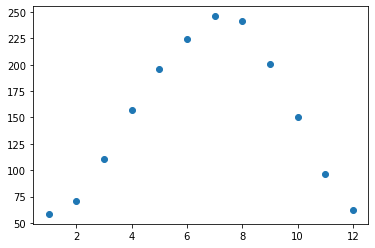

14
(11014, 41)


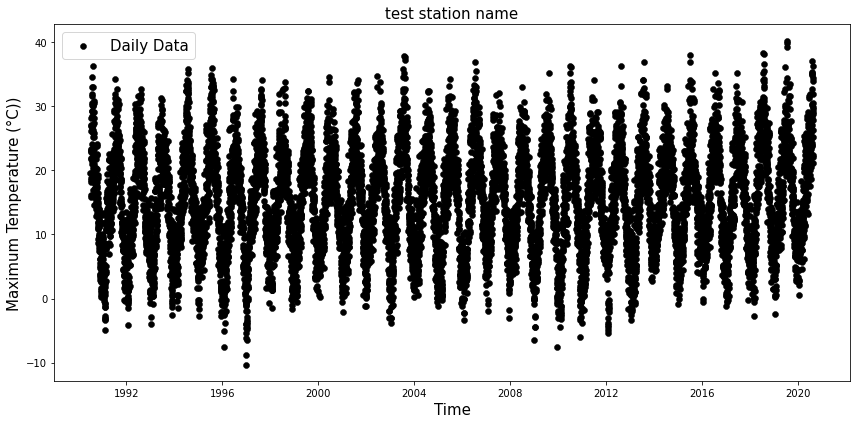

In [87]:
max_temp_index = var_dict['   TX']
print(max_temp_index)

# attempt plot
print(np.shape(mask))

float_dates = mask[:,1]
# Convert the NumPy array of floats to datetime objects
date_int = np.array(float_dates, dtype=int)  # Convert floats to strings
date_strs = np.array(date_int, dtype=str)  # Convert floats to strings
date_objs = np.array([datetime.strptime(date_str, '%Y%m%d') for date_str in date_strs])



labels = list(var_dict.keys())





#for i in range(41):
name = 'name'
i = 14
plt.figure(figsize=(12,6))
plt.scatter(date_objs, mask[:, i]/10, label='Daily Data', color='k', linewidth=0.5)
plt.title('test station name', size=15, )
plt.ylabel('Maximum Temperature (°C))', size=15,)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('name', dpi=300, bbox_inches='tight')
plt.show()

(832432, 41)

2

array([152.1590228, 152.1590228, 152.1590228, 152.1590228, 152.1590228,
       152.1590228, 152.1590228, 152.1590228, 152.1590228, 152.1590228,
       152.1590228, 152.1590228])